# Baseline Subproject - Fine Tuning

## Data Loading

In [1]:
import pandas as pd
import torch
from torch.optim import AdamW  # Import PyTorch's AdamW

from torch.utils.data import DataLoader, Dataset
#from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AdamW

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
train_data = pd.read_csv("cnndm/train_data_base.csv", sep=';')
valid_data = pd.read_csv("cnndm/valid_data_base.csv", sep=';')
test_data = pd.read_csv("cnndm/test_data_base.csv", sep=';')

In [3]:
print(train_data.isna().sum())
missing_rows = train_data[train_data.isna().any(axis=1)]


Unnamed: 0    0
article       0
highlights    0
label         0
dtype: int64


In [4]:
train_data.head()

,Unnamed: 0,article,highlights,label
0,1,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,0
1,2,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,0
2,3,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",0
3,4,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",0
4,5,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",0


## Model and Tokenizer Loading

In [5]:

# Load tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

# Load Longformer model for classification
model = LongformerForSequenceClassification.from_pretrained(
    "allenai/longformer-base-4096",
    num_labels=2  # Binary classification
)

# Check model details
print(model.config)

long_former = True

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LongformerConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "allenai/longformer-base-4096",
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "onnx_export": false,
  "pad_token_id": 1,
  "sep_token_id": 2,
  "transformers_version": "4.47.0",
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [6]:
# # Load the tokenizer and model
# tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
# model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)
# long_former = False

## Token Analysis

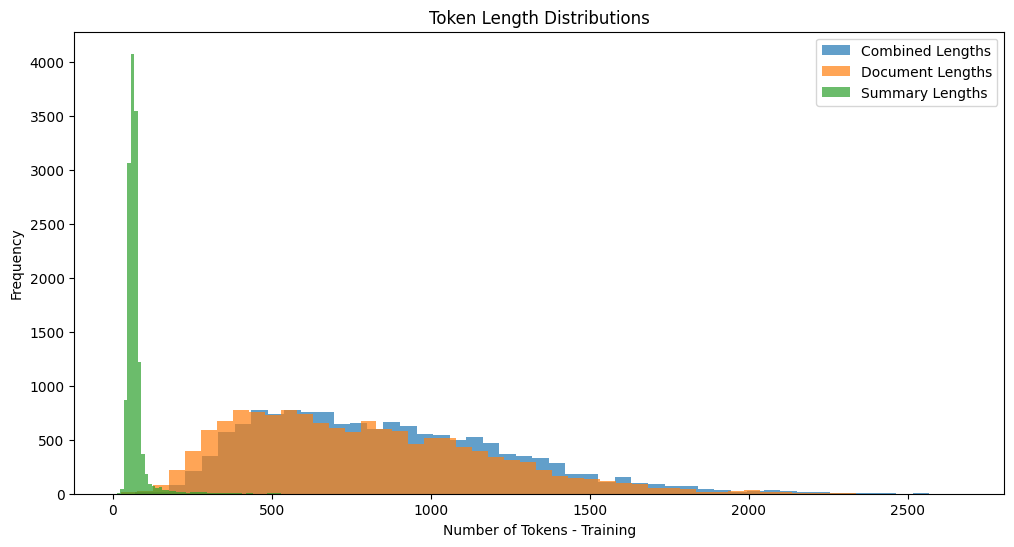

       Document Lengths  Summary Lengths  Combined Lengths
count      13990.000000     13990.000000      13990.000000
mean         783.331665        69.738099        856.069764
std          387.165939        39.269235        394.133228
min           25.000000        12.000000         71.000000
25%          475.000000        54.000000        545.250000
50%          725.000000        64.000000        799.000000
75%         1035.750000        73.000000       1113.000000
max         2538.000000       561.000000       2671.000000


In [7]:
# Tokenize and calculate token lengths
def calculate_lengths(data, tokenizer, column_name):
    lengths = []
    for text in data[column_name]:
        tokens = tokenizer.tokenize(text)
        lengths.append(len(tokens))
    return lengths

# Calculate token lengths for documents and summaries
doc_lengths = calculate_lengths(train_data, tokenizer, column_name='article')
summ_lengths = calculate_lengths(train_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths = [d + s + 3 for d, s in zip(doc_lengths, summ_lengths)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df = pd.DataFrame({
    'Document Lengths': doc_lengths,
    'Summary Lengths': summ_lengths,
    'Combined Lengths': combined_lengths
})

# Plot distributions
plt.figure(figsize=(12, 6))
plt.hist(lengths_df['Combined Lengths'], bins=50, alpha=0.7, label='Combined Lengths')
plt.hist(lengths_df['Document Lengths'], bins=50, alpha=0.7, label='Document Lengths')
plt.hist(lengths_df['Summary Lengths'], bins=50, alpha=0.7, label='Summary Lengths')
#plt.axvline(x=512, color='red', linestyle='--', label='Max Length (512)')
plt.xlabel('Number of Tokens - Training')
plt.ylabel('Frequency')
plt.legend()
plt.title('Token Length Distributions')
plt.show()

# Print statistics
print(lengths_df.describe())


In [8]:
# Calculate token lengths for documents and summaries
doc_lengths_test = calculate_lengths(test_data, tokenizer, column_name='article')
summ_lengths_test = calculate_lengths(test_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths_test = [d + s + 3 for d, s in zip(doc_lengths_test, summ_lengths_test)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df_test = pd.DataFrame({
    'Document Lengths': doc_lengths_test,
    'Summary Lengths': summ_lengths_test,
    'Combined Lengths': combined_lengths_test
})

print(lengths_df_test.describe())



       Document Lengths  Summary Lengths  Combined Lengths
count       1988.000000      1988.000000       1988.000000
mean         779.579477        57.118209        839.697686
std          434.683517        41.748108        444.485520
min          101.000000        14.000000        128.000000
25%          432.000000        38.000000        482.750000
50%          707.500000        48.000000        767.500000
75%         1059.000000        60.000000       1127.000000
max         3110.000000       525.000000       3196.000000


In [9]:
# Calculate token lengths for documents and summaries
doc_lengths_valid = calculate_lengths(valid_data, tokenizer, column_name='article')
summ_lengths_valid = calculate_lengths(valid_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths_valid = [d + s + 3 for d, s in zip(doc_lengths_valid, summ_lengths_valid)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df_valid = pd.DataFrame({
    'Document Lengths': doc_lengths_valid,
    'Summary Lengths': summ_lengths_valid,
    'Combined Lengths': combined_lengths_valid
})

print(lengths_df_valid.describe())

       Document Lengths  Summary Lengths  Combined Lengths
count       1996.000000      1996.000000       1996.000000
mean         800.356713        59.479960        862.836673
std          427.726926        53.781663        437.426265
min          112.000000        12.000000        131.000000
25%          457.000000        37.000000        514.500000
50%          731.500000        48.000000        798.000000
75%         1072.000000        61.000000       1145.500000
max         2206.000000       547.000000       2473.000000


In [10]:
print((lengths_df["Document Lengths"] > 1024).sum())
print((lengths_df_test["Document Lengths"] > 1024).sum())
print((lengths_df_valid["Document Lengths"] > 1024).sum())
print()

print((lengths_df["Document Lengths"] > 2048).sum())
print((lengths_df_test["Document Lengths"] > 2048).sum())
print((lengths_df_valid["Document Lengths"] > 2048).sum())

3614
542
556

62
18
6


In [11]:
print((lengths_df["Combined Lengths"] > 1024).sum())
print((lengths_df_test["Combined Lengths"] > 1024).sum())
print((lengths_df_valid["Combined Lengths"] > 1024).sum())
print()

print((lengths_df["Combined Lengths"] > 2048).sum())
print((lengths_df_test["Combined Lengths"] > 2048).sum())
print((lengths_df_valid["Combined Lengths"] > 2048).sum())

4365
634
633

108
29
21


## Prepare Data for Fine-Tuning

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.examples = []
        self.skipped_count = 0  # Counter for rows skipped due to document length
        self.skipped_bc_chunk = 0  # Counter for rows skipped due to chunking issues

        self._create_examples()

    def _create_examples(self):
        for _, row in self.data.iterrows():
            doc, summ, label = row['article'], row['highlights'], row['label']

            # Tokenize document and summary
            doc_tokens = self.tokenizer.tokenize(doc)
            summ_tokens = self.tokenizer.tokenize(summ)

            # Ensure document fits within max_length alone
            if len(doc_tokens) + 3 > self.max_length:  # [CLS] doc_tokens [SEP]
                self.skipped_count += 1
                continue

            # Function to check if a chunk fits within max_length
            def chunk_fits(tokens_chunk):
                return len(doc_tokens) + len(tokens_chunk) + 3 <= self.max_length

            # Case 1: Check if the full summary fits
            if chunk_fits(summ_tokens):
                input_ids, attention_mask = self._create_input(doc_tokens, summ_tokens)
                self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
            else:
                # Case 2: Try splitting into halves
                mid = len(summ_tokens) // 2
                if chunk_fits(summ_tokens[:mid]) and chunk_fits(summ_tokens[mid:]):
                    for chunk in [summ_tokens[:mid], summ_tokens[mid:]]:
                        input_ids, attention_mask = self._create_input(doc_tokens, chunk)
                        self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
                else:
                    # Case 3: Try splitting into thirds
                    third = len(summ_tokens) // 3
                    chunks = [summ_tokens[:third], summ_tokens[third:2 * third], summ_tokens[2 * third:]]
                    if all(chunk_fits(chunk) for chunk in chunks):
                        for chunk in chunks:
                            input_ids, attention_mask = self._create_input(doc_tokens, chunk)
                            self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
                    else:
                        # Case 4: Skip if none of the strategies work
                        self.skipped_bc_chunk += 1

    def _create_input(self, doc_tokens, summ_tokens):
        input_ids = [self.tokenizer.cls_token_id] + \
                    self.tokenizer.convert_tokens_to_ids(doc_tokens) + \
                    [self.tokenizer.sep_token_id] + \
                    self.tokenizer.convert_tokens_to_ids(summ_tokens) + \
                    [self.tokenizer.sep_token_id]

        attention_mask = [1] * len(input_ids)

        # Pad if necessary
        if len(input_ids) < self.max_length:
            pad_length = self.max_length - len(input_ids)
            input_ids += [self.tokenizer.pad_token_id] * pad_length
            attention_mask += [0] * pad_length

        return input_ids, attention_mask

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        return {
            "input_ids": torch.tensor(example["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.long),
            "label": torch.tensor(example["label"], dtype=torch.long)
        }


In [13]:
# Parameters
if(long_former):
    MAX_LEN = 1024 # 2048 # das setzen wir als balance zwischen wie viele padding brauchen und wie viele rausfallen
else:
    MAX_LEN = 512 # 2048 # das setzen wir als balance zwischen wie viele padding brauchen und wie viele rausfallen

# Prepare datasets
train_dataset = CustomDataset(train_data, tokenizer, max_length=MAX_LEN)
valid_dataset = CustomDataset(valid_data, tokenizer, max_length=MAX_LEN)
test_dataset = CustomDataset(test_data, tokenizer, max_length=MAX_LEN)


In [14]:
# How many observations fall out
print(f'Train: {train_dataset.skipped_count}/{train_data.shape[0]} ~ {train_dataset.skipped_count/train_data.shape[0] * 100} %')
print(f'Test: {test_dataset.skipped_count}/{test_data.shape[0]} ~ {test_dataset.skipped_count/test_data.shape[0] * 100} %')
print(f'Valid: {valid_dataset.skipped_count}/{valid_data.shape[0]} ~ {valid_dataset.skipped_count/valid_data.shape[0] * 100} %')

Train: 3642/13990 ~ 26.032880629020728 %
Test: 544/1988 ~ 27.364185110663986 %
Valid: 558/1996 ~ 27.955911823647295 %


In [15]:
print(f'Train: {train_dataset.skipped_bc_chunk}/{train_data.shape[0]} ~ {train_dataset.skipped_bc_chunk/train_data.shape[0] * 100} %')
print(f'Test: {test_dataset.skipped_bc_chunk}/{test_data.shape[0]} ~ {test_dataset.skipped_bc_chunk/test_data.shape[0] * 100} %')
print(f'Valid: {valid_dataset.skipped_bc_chunk}/{valid_data.shape[0]} ~ {valid_dataset.skipped_bc_chunk/valid_data.shape[0] * 100} %')

Train: 241/13990 ~ 1.7226590421729808 %
Test: 34/1988 ~ 1.710261569416499 %
Valid: 20/1996 ~ 1.002004008016032 %


In [16]:
if(long_former):
    BATCH_SIZE = 16
else:
    MAX_LEN = 32 

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

cuda


c:\Users\Mocca\anaconda3\envs\adl_project\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch_idx, batch in enumerate(data_loader):
        # Access the current batch index
        print(f"Processing batch {batch_idx + 1}/{len(data_loader)}", end = '\r')

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        losses.append(loss.item())

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses)



In [19]:
def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            losses.append(loss.item())

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses)


## Fine-Tuning

In [20]:
torch.cuda.empty_cache()

In [23]:
EPOCHS = 20  # Maximum number of epochs
PATIENCE = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
early_stopping_counter = 0  # Tracks epochs without improvement

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Train for one epoch
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Evaluate on validation set
    val_acc, val_loss = eval_model(model, valid_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset counter if performance improves
        torch.save(model.state_dict(), 'models/best_model_state.bin')  # Save the best model
        print("Validation performance improved. Model saved.")
    else:
        early_stopping_counter += 1  # Increment counter if no improvement
        print(f"No improvement. Early stopping counter: {early_stopping_counter}/{PATIENCE}")

    # Stop training if early stopping criteria are met
    if early_stopping_counter >= PATIENCE:
        print("Early stopping triggered. Training stopped.")
        break


Epoch 1/20
----------


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('models/best_model_state.bin', weights_only=True))

test_acc, test_loss = eval_model(model, test_loader, criterion, device)
print(f'Test loss: {test_loss} | Test accuracy: {test_acc}')

# Classification report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


Test loss: 0.36819470893930306 | Test accuracy: 0.8464912280701754
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       337
           1       0.81      0.91      0.86       347

    accuracy                           0.85       684
   macro avg       0.85      0.85      0.85       684
weighted avg       0.85      0.85      0.85       684

